## 뇌 ct 사진으로 치매 예측


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
# 기존 경로 변경
os.chdir('/content/drive/MyDrive/AI/dataset')

In [6]:
%pwd

'/content/drive/MyDrive/AI/dataset'

In [7]:
import zipfile
if not os.path.exists('brain'):
  path='brain.zip'
  f_zip=zipfile.ZipFile(path)
  f_zip.extractall('./')
  f_zip.close()

## 텐서플로우 함수형 모델링

In [11]:
import tensorflow as tf
from tensorflow.keras import layers


def bt_block(inputs, filters):
    skipconv = layers.Conv2D(filters*4, 1, 2, use_bias=False)
    skipbn = layers.BatchNormalization()

    conv1 = layers.Conv2D(filters, 1, 1, use_bias=False)
    conv2 = layers.Conv2D(filters, 3, 2, padding='same', use_bias=False)
    conv3 = layers.Conv2D(filters*4, 1, 1,use_bias=False)

    bn1 = layers.BatchNormalization()
    bn2 = layers.BatchNormalization()
    bn3 = layers.BatchNormalization()

    active = layers.LeakyReLU()
    add = layers.Add()

    x = conv1(inputs)
    x = bn1(x)
    x = active(x)

    x = conv2(x)
    x = bn2(x)
    x = active(x)

    x = conv3(x)
    x = bn3(x)
    x = active(x)

    shortcut = skipconv(inputs)
    shortcut = skipbn(shortcut)

    x = x + shortcut
    return x

rescale = layers.Rescaling(1./127.5, offset=-1)
global_pooling = layers.GlobalAveragePooling2D()
bn = layers.BatchNormalization()
dr = layers.Dropout(0.4)
dense1 = layers.Dense(64)
dense2 = layers.Dense(2)
softmax = layers.Softmax()


inp = tf.keras.Input((64,64,1))
x = rescale(inp)
x = bt_block(x, 16)
x = bt_block(x, 32)
x = bt_block(x, 32)
x = bt_block(x, 64)
x = bt_block(x, 64)

x = global_pooling(x)
x = bn(x)
x = dr(x)
x = dense1(x)
x = dense2(x)
out = softmax(x)

model = tf.keras.Model(inp, out, name = 'bt_cnn') # (4)
model.summary()

Model: "bt_cnn"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 64, 64, 1)            0         ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 64, 16)           16        ['rescaling[0][0]']           
                                                                                                  
 batch_normalization_2 (Bat  (None, 64, 64, 16)           64        ['conv2d_1[0][0]']            
 chNormalization)                                                                            

## 파이토치 객체지향 모델링
케라스의 클래스 기반 모델링 방식과 거의 비슷한 구조
- `__init__()` 에서 레이어 인스턴스 생성(keras와 동일)
- `forward()` 에서 레이어의 순전파 구성(keras의 call함수와 동일)
- 레이어 인스턴스 생성시 입력 텐서의 모양도 인자로 입력해야함
- Conv2d 레이어의 기본 입력 구조 순서는 채널이 먼저 (B, C, H, W)

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

class BTBlock(nn.Module):
    def __init__(self, in_filters, out_filters):
        super(BTBlock, self).__init__()
        self.skip = nn.Conv2d(in_filters, out_filters * 4, kernel_size=1, stride=2, padding=0, bias=False)

        self.conv1 = nn.Conv2d(in_filters, out_filters, kernel_size=1, stride=1, padding=0, bias=False)
        self.conv2 = nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=2, padding=1, bias=False)
        self.conv3 = nn.Conv2d(out_filters, out_filters * 4, kernel_size=1, stride=1, padding=0, bias=False)

        self.bn1 = nn.BatchNorm2d(out_filters)
        self.bn2 = nn.BatchNorm2d(out_filters)
        self.bn3 = nn.BatchNorm2d(out_filters * 4)

    def forward(self, x):
        shortcut = self.skip(x)

        x = self.conv1(x)
        x = self.bn1(x)
        x = F.leaky_relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.leaky_relu(x)

        x = self.conv3(x)
        x = self.bn3(x)

        x = x + shortcut
        return x

class BTCNN(nn.Module):
    def __init__(self):
        super(BTCNN, self).__init__()

        self.bt1 = BTBlock(1,16)  # 입력 모양 :  ( b , x ,  y, 1 )
        self.bt2 = BTBlock(16*4,32)
        self.bt3 = BTBlock(32*4,32)
        self.bt4 = BTBlock(32*4,64)
        self.bt5 = BTBlock(64*4,64)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.bn = nn.BatchNorm1d(64*4)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64*4, 64)
        self.fc2 = nn.Linear(64, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # x : (batch, 1, 64, 64)
        x = self.bt1(x)
        x = self.bt2(x)
        x = self.bt3(x)
        x = self.bt4(x)
        x = self.bt5(x)

        x = self.global_pool(x)
        x = self.bn(x.view(-1, 64*4)) # reshape (b,1,1,256) -> (b,256)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

## 텐서플로우 데이터세트 로드

In [13]:
tf.__version__

'2.15.0'

Found 2800 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


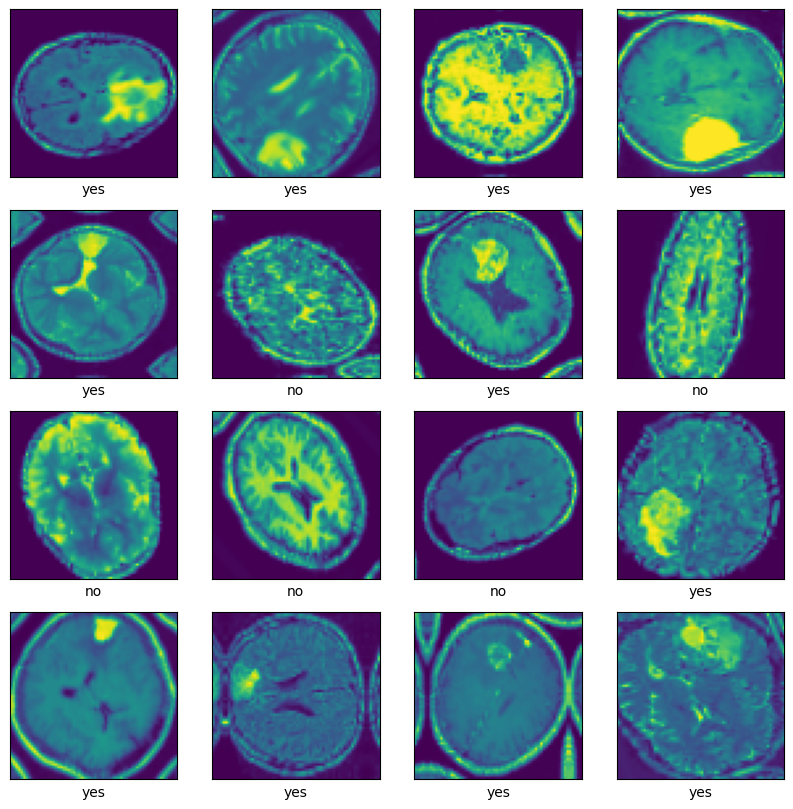

In [14]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt


train_ds = tf.keras.utils.image_dataset_from_directory(
    './brain/train',
    label_mode='int',
    color_mode='grayscale',
    batch_size=16,
    image_size=(64, 64),
    shuffle=True,
    seed = 1
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    './brain/valid',
    label_mode='int',
    color_mode='grayscale',
    batch_size=16,
    image_size=(64, 64),
    seed = 1
)


train_aug = tf.keras.Sequential([
        layers.RandomBrightness(0.2),
        layers.RandomRotation(0.5),
        layers.RandomZoom(0.2,0.2)])

class_names = train_ds.class_names
train_ds = train_ds.map(lambda x,y : (train_aug(x),y))
train_ds = train_ds.prefetch(buffer_size=100) # (2)

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    i = 0
    for img, label in zip(images, labels):
        i+=1
        plt.subplot(4,4,i)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img)
        plt.xlabel(class_names[label])

## 파이토치 데이터세트 로드
- Dataset 객체로 기본 데이터세트의 뼈대 구성
- DataLoader 객체로 Dataset을 학습을 위한 파라미터를 설정하여 로드
- transforms 모듈을 활용하여 이미지 전처리하여 로드 가능(keras의 map과 비슷)

torch.Size([1, 64, 64])


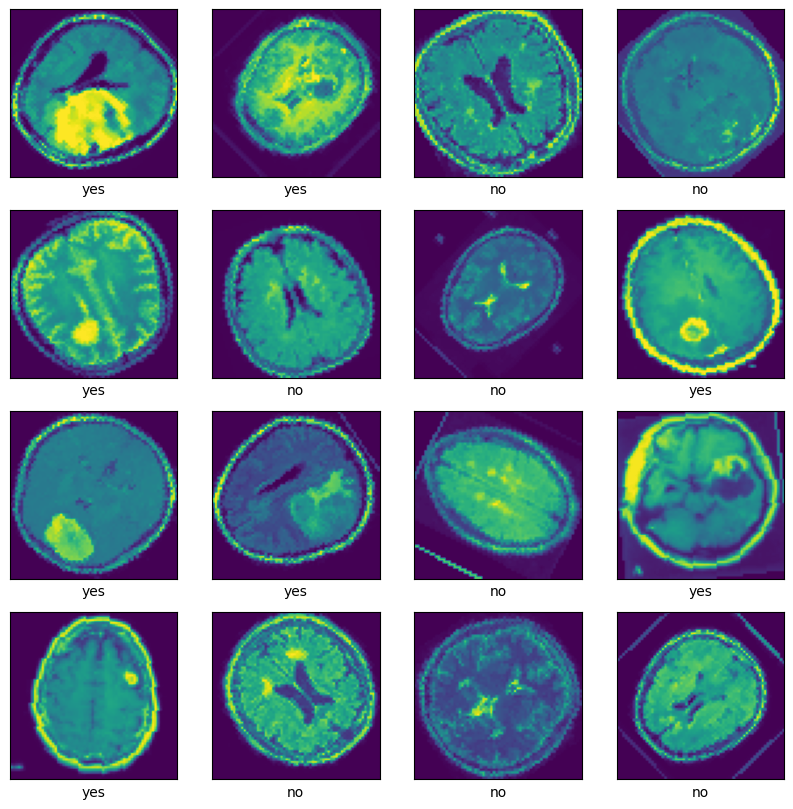

In [15]:
# torchvision의 datasets 모듈 활용(이미지)
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt


# transforms 모듈로 이미지 전처리 과정 구성
train_transforms = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((64,64)),
    transforms.ColorJitter(brightness=.2),
    transforms.RandomRotation(degrees=(0, 180)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229]) # 그레이컬러 zscore 스케일
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # RGB 컬러
])

val_transforms = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229]) # 스케일
])

# ImageFolder를 활용하여 이미지 경로로 부터 DataSet 인스턴스 생성
train_set = datasets.ImageFolder('./brain/train',
                                 transform = train_transforms)
val_set = datasets.ImageFolder('./brain/valid',
                               transform = val_transforms)
class_names = train_set.classes

# DataSet 인스턴스 및 학습 파라미터를 설정하여 DataLoader 인스턴스 생성
train_loader = DataLoader(train_set,
                          batch_size=16,
                          shuffle=True)

val_loader = DataLoader(val_set,
                        batch_size=16,
                        shuffle=False)

# 출력해보기
plt.figure(figsize=(10,10))
for images, labels in train_loader:
    print(images[0].shape)
    i = 0
    for img, label in zip(images, labels):
        i+=1
        plt.subplot(4,4,i)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img.permute((1,2,0)))
        plt.xlabel(class_names[label])
    break

## 파이토치 커스텀 Dataset로 로드
- `Dataset`를 상속하여 콜백함수의 내용을 작성
- `__init__()` 기본 정보 초기화, 가장 먼저 실행   
- `__len__()` 데이터의 총개수를 리턴, `__init__()` 이후에 실행   
- `__getitem__(idx)` 입력 텐서데이터 하나의 구성을 리턴, 반복문이나 next()함수등으로 호출시 실행

torch.Size([1, 64, 64])


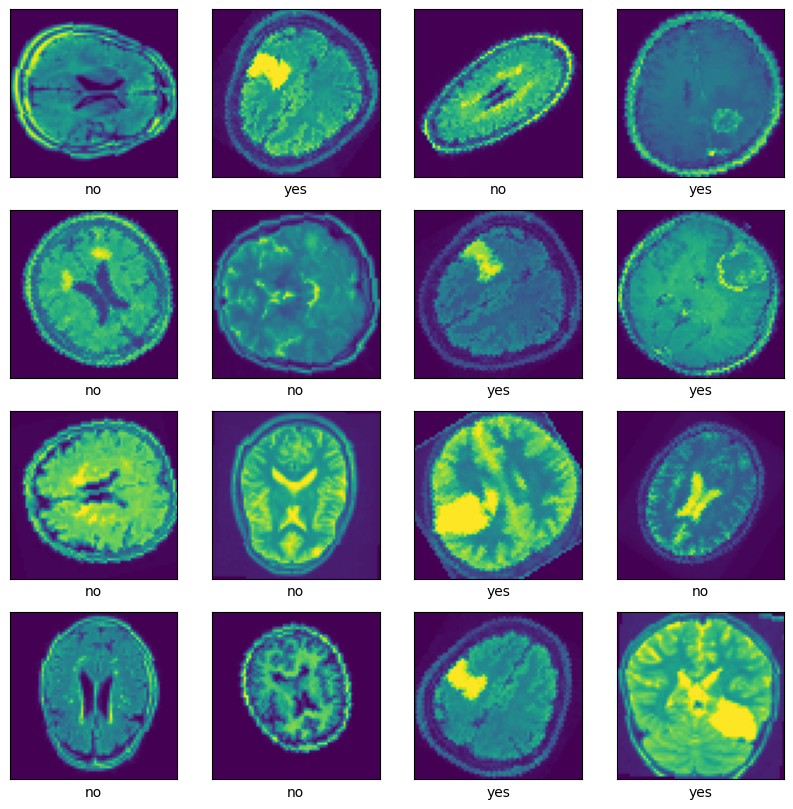

In [16]:
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from pathlib import Path
# Dataset 상속
class CustomImageDataset(Dataset):
    # 기본 정보 초기화
    def __init__(self, img_dir, transform=None):
        self.transform = transform
        root = Path(img_dir)
        self.paths = list(root.glob('*/*.jpg'))
        self.class_name = ['no','yes']
        self.cindex = {'no':0,'yes':1}

    # 데이터의 총 개수가 리턴
    def __len__(self):
        return len(self.paths)

    # idx 인자에 호출될 데이터의 인덱스가 입력됨
    # 입력데이터 하나의 구성을 리턴
    def __getitem__(self, idx):
        path = self.paths[idx]
        label = path.parts[-2]
        image = Image.open(path)
        if self.transform:
            image = self.transform(image)
        return image, self.cindex[label]


train_set = CustomImageDataset('./brain/train',
                                 transform = train_transforms)

val_set = CustomImageDataset('./brain/valid',
                               transform = val_transforms)

class_names = train_set.class_name

train_loader = DataLoader(train_set,
                          batch_size=16,
                          shuffle=True)

val_loader = DataLoader(val_set,
                        batch_size=16,
                        shuffle=False)

plt.figure(figsize=(10,10))
for images, labels in train_loader:
    print(images[0].shape)
    i = 0
    for img, label in zip(images, labels):
        i+=1
        plt.subplot(4,4,i)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img.permute((1,2,0)))
        plt.xlabel(class_names[label])
    break

## 텐서플로우 학습 로직

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_path = "/checkpoint/cp.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only = True,
                                                 verbose=1)

model.fit(train_ds, epochs=50, validation_data = val_ds, callbacks=[cp_callback])

model.load_weights(checkpoint_path)

model.save("model1")

## 파이토치 학습 로직
파이토치는 학습로직을 직접 코드로 작성

In [ ]:
import os

# 가속화 디바이스 선택(GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 모델 인스턴스 생성
model = BTCNN().to(device)
# 옵티마이져 인스턴스 생성
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# 손실함수 생성
# 파이토치 CrossEntropyLoss = 케라스 SparseCategoricalCrossentropy
loss_fn = nn.CrossEntropyLoss() #

# 체크포인트 경로 생성
if not os.path.isdir('/checkpoint'):
    os.mkdir('/checkpoint')

# 손실 히스토리 리스트
train_loss = []
test_loss = []

# 학습 루프
for epoch in range(20):

    t_acc = 0
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        # 순방향 전파
        outputs = model(images)
        # 손실 계산
        loss = loss_fn(outputs, labels)
        # 역방향 전파 및 파라미터 업데이트
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 정확도 계산
        acc = (outputs.argmax(dim=1) == labels).sum() / len(labels)

        t_acc += acc
        if i % 30 == 0:
            # 30배치마다 평균 손실 및 정확도 출력
            print(f"Epoch: {epoch}, Batch: {i}, Loss: {loss.item()}, Accuracy: {t_acc/(i+1)}")

    train_loss.append(loss.item())
    # 에포크 마다 체크포인트 저장
    checkpoint_path = f"/checkpoint/ckpt{epoch}.pt"
    torch.save(model.state_dict(), checkpoint_path)

    # 평가
    v_acc = 0
    model.eval()
    with torch.no_grad():  # 기울기 계산 X
        for i, (images, labels) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            acc = (outputs.argmax(dim=1) == labels).sum() / len(labels)
            v_acc += acc

        print(f"Epoch: {epoch}, Val_Loss: {loss.item()}, Val_Accuracy: {v_acc/(i+1)}")
        test_loss.append(loss.item())

# 모델 저장
torch.save(model, "model1.pt")

In [ ]:
plt.plot(range(len(train_loss)),train_loss)
plt.plot(range(len(test_loss)),test_loss)
plt.show()

## 파이토치 사전 학습 모델 활용
torchvision.models 에서 원하는 사전학습 모델 사용가능   
https://pytorch.org/vision/main/models.html

In [ ]:

import torch
import torchvision.models as models
from torch import nn

# 이피션트넷 모델 가져오기
model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)

# 기본 분류 레이어 제거
model.classifier = nn.Identity()

# 모델 정보 출력
print(model)


In [ ]:
class EFCNN(nn.Module):
    def __init__(self):
        super(EFCNN, self).__init__()
        # 그레이 => RGB
        self.conv = nn.Conv2d(1, 3, kernel_size=3, stride=1, padding=1)
        self.model = models.mobilenet_v3_small(
            weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
        nn_feature = self.model.classifier[0].in_features
        self.model.classifier = nn.Identity()
        self.fc1 = nn.Linear(nn_feature, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv(x)
        x = self.model(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.softmax(self.fc2(x))
        return x

In [ ]:
import os

model_name = "model_mb"
# 가속화 디바이스 선택(GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 모델 인스턴스 생성
model = EFCNN().to(device)
# 옵티마이져 인스턴스 생성
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# 손실함수 생성
# 파이토치 CrossEntropyLoss = 케라스 SparseCategoricalCrossentropy
loss_fn = nn.CrossEntropyLoss() #

# 체크포인트 경로 생성
if not os.path.isdir('/checkpoint'):
    os.mkdir('/checkpoint')

# 손실 히스토리 리스트
train_loss = []
test_loss = []

# 학습 루프
for epoch in range(20):

    t_acc = 0
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        # 순방향 전파
        outputs = model(images)
        # 손실 계산
        loss = loss_fn(outputs, labels)
        # 역방향 전파 및 파라미터 업데이트
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 정확도 계산
        acc = (outputs.argmax(dim=1) == labels).sum() / len(labels)

        t_acc += acc
        if i % 30 == 0:
            # 30배치마다 평균 손실 및 정확도 출력
            print(f"Epoch: {epoch}, Batch: {i}, Loss: {loss.item()}, Accuracy: {t_acc/(i+1)}")

    train_loss.append(loss.item())
    # 에포크 마다 체크포인트 저장
    checkpoint_path = f"/checkpoint/ckpt_{model_name}{epoch}.pt"
    torch.save(model.state_dict(), checkpoint_path)

    # 평가
    v_acc = 0
    model.eval()
    with torch.no_grad():  # 기울기 계산 X
        for i, (images, labels) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            acc = (outputs.argmax(dim=1) == labels).sum() / len(labels)
            v_acc += acc

        print(f"Epoch: {epoch}, Val_Loss: {loss.item()}, Val_Accuracy: {v_acc/(i+1)}")
        test_loss.append(loss.item())

# 모델 저장
torch.save(model, f"{model_name}.pt")

In [ ]:
plt.plot(range(len(train_loss)),train_loss)
plt.plot(range(len(test_loss)),test_loss)
plt.show()